In [1]:
import pandas as pd
import seaborn as sns
import os 
import sklearn as sk
import matplotlib.pyplot as plt

In [22]:
df_dict = {}

for file in os.listdir("./final_data"):
   if file.endswith(".tsv"):
        filename = os.path.splitext(os.path.basename(file))[0]
        print(filename)
        temp_df = pd.read_csv(os.path.join('./final_data', file), delimiter='\t')
        df_dict[filename] = temp_df

fun
proff
bowls
jewel
papyrus
games
toil
furn
met
boxbas
shabtis
amph
cost
pers
jars
coffins
fertil
lotus_converted


In [ ]:
from sklearn.preprocessing import StandardScaler
# set up cost dataframe for kmeans clustering 
cost_df = df_dict['cost']

# since coffins column is missing values, add the coffin column from coffins.tsv
coffins_df = df_dict['coffins']
merged_df = cost_df.merge(coffins_df, left_on="coffins", right_on="total_cost", how="left")
cost_df["coffins"] = cost_df["coffins"].fillna(merged_df["coffins"])

# some of the missing values have different keys - filling in manually
# found this value in coffins_df
cost_df.at[0, "coffins"] = 590.0
# cannot find k&m in coffins_df, in paper, it says that Kha and Merit are similar to Yuya and Tuya, so filling their coffin value wih 590
cost_df.at[2, "coffins"] = 590.0

# filling in missing jewelry values
jewel_df = df_dict['jewel']
# putting 0 for iabtina because appendix in paper says there is no jewlery (but jewlery table in paper has miscellaneus items for her? not sure)
cost_df.at[25, "jewlery"] = 0
# cannot find data for NuMan, putting 85 which is the average of the rank above and rank below cost on jewelry
cost_df.at[75, "jewlery"] = 85
cost_df = cost_df.rename(columns = {"jewlery" : "jewelry"})

# filling in missing values for profess
proff_df = df_dict['proff']
# no professional equipment for Sat-Re, filling in 0
cost_df.at[29, "profess"] = 0

# filling in missing values for toiletries 
# no information about toiletries for Khay, filling in the average of the rank above and below
cost_df.at[5, "toiletries"] = 13.5
# drop some repeat tombs
cost_df = cost_df[~cost_df['tomb'].isin(['Yuya','Kha', 'Merit', "Tuya"])]


print(cost_df.isnull().sum())
feature_matrix = cost_df.drop(['tomb', 'rank'], axis=1)
feature_matrix = StandardScaler().fit_transform(feature_matrix)


tomb           0
rank           0
grand_total    0
amphorae       0
bouquet        0
bowls          0
boxbas         0
coffins        0
fertility      0
funerary       0
furniture      0
jars           0
jewelry        0
personal       0
profess        0
shabti         0
toiletries     0
vessels        0
dtype: int64


In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
feature_matrix = pca.fit_transform(feature_matrix)

In [72]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(feature_matrix)
cost_df["cluster"] = kmeans.labels_

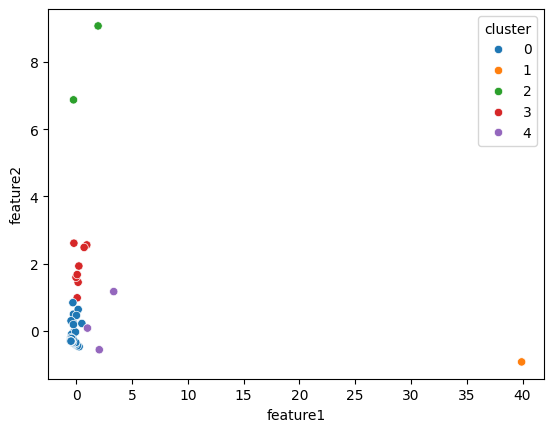

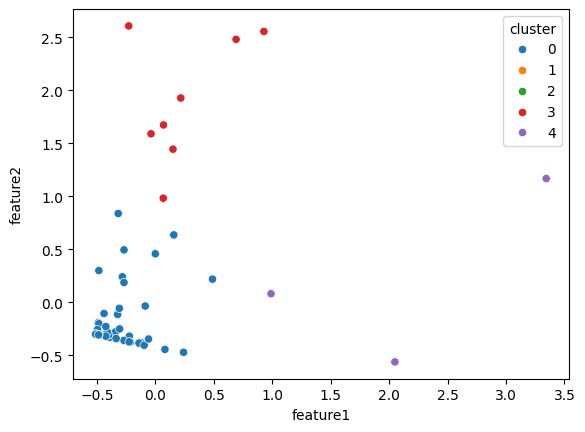

In [73]:
fm_df = pd.DataFrame(feature_matrix)
fm_df['cluster'] = kmeans.labels_
fm_df.columns = ['feature1', 'feature2', 'cluster']

cluster_order = sorted(fm_df['cluster'].unique())
base_palette = sns.color_palette('tab10', len(cluster_order))
cluster_colors = {c: base_palette[i] for i, c in enumerate(cluster_order)}

sns.scatterplot(data=fm_df, x='feature1', y='feature2', hue='cluster',
                palette=cluster_colors, hue_order=cluster_order)
plt.show()

filtered = fm_df[~fm_df['cluster'].isin([1, 2])]

plt.clf()
sns.scatterplot(data=filtered, x='feature1', y='feature2', hue='cluster',
                palette=cluster_colors, hue_order=cluster_order)
plt.show()


In [74]:
display_df = cost_df.filter(['tomb', 'cluster'], axis=1)
display_df.to_csv("kmeans_output.csv", index=False)

In [75]:
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors

df = pd.read_csv('kmeans_output.csv')
clusters = sorted(df['cluster'].unique())
lists = [df[df['cluster']==c]['tomb'].tolist() for c in clusters]
max_len = max(len(lst) for lst in lists)
table_data = [[str(c) for c in clusters]]
for i in range(max_len):
    row = [(lists[j][i] if i < len(lists[j]) else '') for j in range(len(clusters))]
    table_data.append(row)
doc = SimpleDocTemplate('clusters_table.pdf', pagesize=letter)
table = Table(table_data)
style = TableStyle([('GRID', (0,0), (-1,-1), 1, colors.black), ('BACKGROUND', (0,0), (-1,0), colors.grey)])
table.setStyle(style)
doc.build([table])


In [94]:
c0_df = cost_df[cost_df["cluster"] == 0]
c1_df = cost_df[cost_df["cluster"] == 1]
c2_df = cost_df[cost_df["cluster"] == 2]
c3_df = cost_df[cost_df["cluster"] == 3]
c4_df = cost_df[cost_df["cluster"] == 4]

df_list = [c0_df, c2_df, c3_df, c4_df]


Cluster Number 0.0


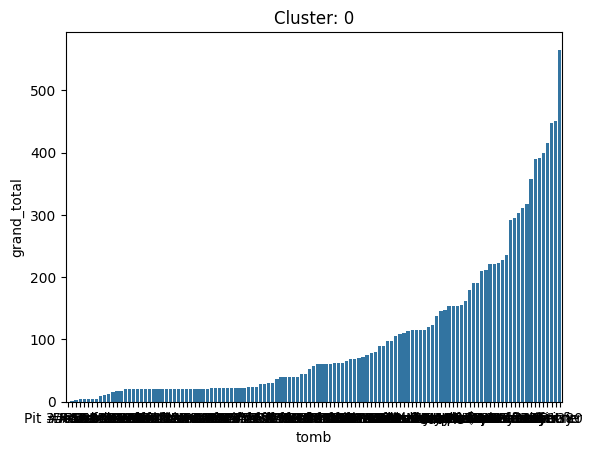

Cluster Number 2.0


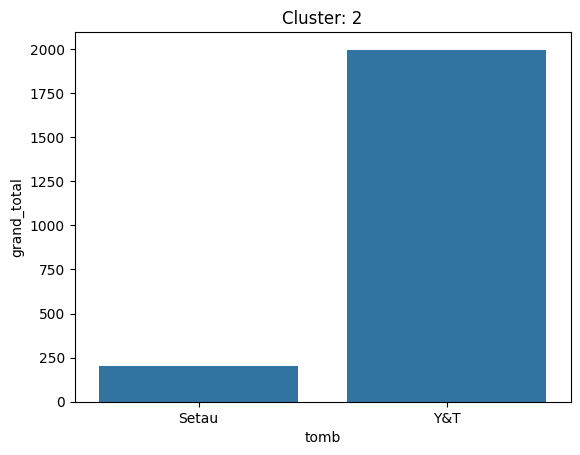

Cluster Number 3.0


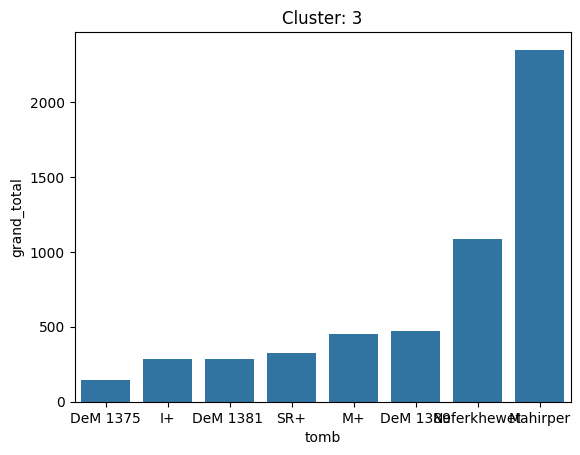

Cluster Number 4.0


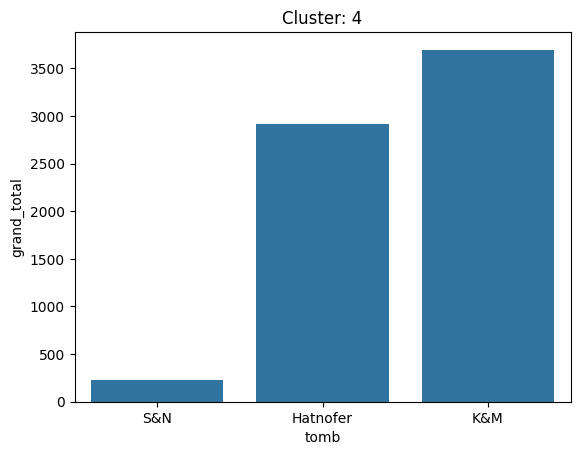

In [ ]:
for df in df_list:
    clus_num = df["cluster"].mean()
    print(f"Cluster Number {int(clus_num)}")
    plt.clf()
    sns.barplot(df, x="tomb", y="grand_total", order = df.sort_values("grand_total").tomb).set_title(f"Cluster: {int(clus_num)}")
    plt.show()


In [ ]:
for df in df_list:
    clus_num = df["cluster"].mean()
    print(f"Cluster Number {int(clus_num)}")
    print(df.describe())
    plt.clf()
    # sns.barplot(df, x="tomb", y="fertility", order = df.sort_values("fertility").tomb).set_title(f"Cluster: {int(clus_num)}")
    plt.show()

Cluster Number 0.0
             rank  grand_total    amphorae     bouquet       bowls  \
count  121.000000   121.000000  121.000000  121.000000  121.000000   
mean    25.239339   100.280992    0.280992    0.148760    0.685950   
std      9.731093   116.860617    2.736248    1.115506    2.446198   
min      5.000000     0.000000    0.000000    0.000000    0.000000   
25%     19.050000    20.000000    0.000000    0.000000    0.000000   
50%     27.300000    57.000000    0.000000    0.000000    0.000000   
75%     33.860000   138.000000    0.000000    0.000000    0.000000   
max     50.000000   565.500000   30.000000   12.000000   17.000000   

           boxbas     coffins   fertility    funerary   furniture        jars  \
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000   
mean     3.223140   47.685950    0.070248   13.347107    1.909091    3.768595   
std     11.727807   35.449737    0.419850   28.316577    6.966587   17.592025   
min      0.000000    0.000

<Figure size 640x480 with 0 Axes>

Cluster Number 2.0
            rank  grand_total  amphorae  bouquet  bowls      boxbas  \
count   2.000000     2.000000  2.000000      2.0    2.0    2.000000   
mean    6.550000  1098.500000  1.000000      0.0    0.0   67.500000   
std     6.434672  1269.256672  1.414214      0.0    0.0   95.459415   
min     2.000000   201.000000  0.000000      0.0    0.0    0.000000   
25%     4.275000   649.750000  0.500000      0.0    0.0   33.750000   
50%     6.550000  1098.500000  1.000000      0.0    0.0   67.500000   
75%     8.825000  1547.250000  1.500000      0.0    0.0  101.250000   
max    11.100000  1996.000000  2.000000      0.0    0.0  135.000000   

          coffins  fertility  funerary  furniture         jars    jewelry  \
count    2.000000   2.000000       2.0    2.00000     2.000000   2.000000   
mean   342.500000  22.000000       0.0  158.50000   660.000000  20.000000   
std    350.017857  11.313708       0.0  224.15285   933.380951  28.284271   
min     95.000000  14.000000     

<Figure size 640x480 with 0 Axes>

Cluster Number 3.0
            rank  grand_total   amphorae   bouquet      bowls    boxbas  \
count   8.000000     8.000000   8.000000  8.000000   8.000000   8.00000   
mean   15.300000   675.812500   9.000000  0.625000  23.625000  26.75000   
std     6.461313   733.211134  13.005493  0.916125  20.839094  22.00487   
min     3.000000   147.500000   0.000000  0.000000   6.000000   3.00000   
25%    12.750000   286.875000   2.000000  0.000000   8.500000  14.25000   
50%    17.000000   389.250000   2.000000  0.000000  20.000000  21.00000   
75%    20.250000   627.125000  10.500000  1.250000  27.250000  31.25000   
max    21.400000  2348.500000  30.000000  2.000000  70.000000  69.00000   

          coffins  fertility    funerary  furniture        jars    jewelry  \
count    8.000000   8.000000    8.000000    8.00000    8.000000    8.00000   
mean   195.625000   2.500000   45.625000   19.37500  170.875000  139.25000   
std    245.159387   3.615443   54.211062   25.90608  135.711288  314.82

<Figure size 640x480 with 0 Axes>

Cluster Number 4.0
       rank  grand_total    amphorae    bouquet     bowls     boxbas  \
count   3.0     3.000000    3.000000   3.000000  3.000000   3.000000   
mean    8.0  2282.833333   86.666667   9.666667  4.666667  51.333333   
std     4.0  1817.168287   55.075705   8.736895  3.785939  41.501004   
min     4.0   233.000000   30.000000   0.000000  2.000000  10.000000   
25%     6.0  1576.250000   60.000000   6.000000  2.500000  30.500000   
50%     8.0  2919.500000   90.000000  12.000000  3.000000  51.000000   
75%    10.0  3307.750000  115.000000  14.500000  6.000000  72.000000   
max    12.0  3696.000000  140.000000  17.000000  9.000000  93.000000   

          coffins  fertility    funerary   furniture        jars     jewelry  \
count    3.000000        3.0    3.000000    3.000000    3.000000    3.000000   
mean   260.000000        0.0   41.666667  113.333333   84.000000   61.333333   
std    285.788383        0.0   72.168784  129.218162  135.159165  106.232450   
min     95.0

<Figure size 640x480 with 0 Axes>

In [103]:
def ves_percent(row):
    if row["grand_total"] != 0:
        return row["vessels"] / row["grand_total"]
    else:
        return 0

for df in df_list:
    df = df.copy()
    clus_num = df["cluster"].mean()
    print(f"Cluster Number {int(clus_num)}")
    df["ves_percent"] = df.apply(ves_percent, axis=1)
    print(df["ves_percent"].mean())
    print(df["ves_percent"].max())

Cluster Number 0
0.0029413496778032235
0.20179372197309417
Cluster Number 2
0.02630260521042084
0.05260521042084168
Cluster Number 3
0.006773938305099425
0.04141739530602853
Cluster Number 4
0.3667952478752858
0.45064377682403434
